# Calculating handicaps for WOBYC dinghy racing
This notebook was originally created for Waveney and Oulton Broad Yacht Club to demonstrate the calculation of a personalised handicap for the Oulton Rater XX2, for use in club dinghy racing. The data for XX2 is used with permission, and all other personal data has been redacted to comply with GDPR.

In a sailing race a boat's finish time $t$ is modified by the handicap $PY$ (also known as the PY number)  to give the corrected time $T_\textrm{corrected} = \frac{1000\, T}{PY}$. Dinghies generally have values of around $PY \approx 1000$, with larger handicaps corresponding to slower boats.

To compute a personalised handicap for the boat 'XX2', we assume that in each race it should attain a corrected time equal to the median corrected time. This allows us to compute a personalised handicap for each race
\begin{equation}
PY_r = \frac{1000 \, T_\textrm{XX2}}{\textrm{median}(T_\textrm{corrected})}.
\end{equation}
The value of $PY_r$ will vary significantly between races depending on the performance of 'XX2', but a good estimate of the true handicap can be obtained by taking the median of the personalised handicap of each individual race
\begin{equation}
PY_\textrm{XX2} \approx \textrm{median}(PY_r)
\end{equation}
Note that the median is used here to ensure outliers do not skew the handicap; this will be discussed further on.


We start by loading the necessary Python packages:

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

The function `anonymise` is used to redact personal data from a pandas `DataFrame` before displaying to comply with GDPR:

In [2]:
def anonymise(df):
    df2 = df.copy()
    for col in ['HelmName', 'CrewName', 'SailNo', 'Boat', 'Class', 'PY', 'Elapsed', 'Corrected']:
        if col in df.columns:
            df2[col] = 'redacted (' + type(df2[col].iloc[0]).__name__ + ')'
    return df2

We're going to want to download some race data from the WOBYC website. We can use the requests package along with BeautifulSoup to parse Sailwave race tables from a chosen URL, which can then be loaded into a Pandas `DataFrame`:

We define the function `sailwave_to_df` to automatically load an html race table into a `DataFrame` and clean up the data. Note that we recompute the elapsed time from the corrected time instead of using the `'Elapsed'` column in the original data; this is to avoid problems with average lap races.

In [3]:
def sailwave_to_df(race, year):
    try:
        """Converts a Sailwave table in html format to a pandas dataframe"""
        df = pd.read_html(race, index_col='Rank')[0]
        df = df[['HelmName', 'Class', 'SailNo', 'PY', 'Corrected']]
        df['SailNo'] = df['SailNo'].astype('string')
        df['Class'] = df['Class'].astype('string')
        df['PY'] = df['PY'].astype('int')
        df['Corrected'] = pd.to_timedelta(df['Corrected']).dt.total_seconds()
        df['Corrected'] = df['Corrected'].fillna(df['Corrected'].max()) # DNF defaults to the slowest boat in the race
        df = df[df['Corrected'] > 0] # drop races where average points were awarded
        df['Elapsed'] = df['Corrected'] * df['PY'] / 1000
        df['Year'] = year   
        return df
    except KeyError:
        raise

We also define the function `scrape_sailwave` which scrapes a given URL for sailwave race tables and returns a list of races in `DataFrame` format using `sailwave_to_df`:

In [4]:
def scrape_sailwave(url, year):
    race_list = []
    for link in BeautifulSoup(requests.get(url).text, "lxml").find_all('a'):
        anchor = link.attrs["href"] if "href" in link.attrs else ''
        if anchor.endswith('htm') or anchor.endswith('html'):
            soup = BeautifulSoup(requests.get(anchor).text, "lxml")
            tables = soup.find_all('table', attrs={'class': 'racetable'})
            for race in tables:
                try:
                    temp = sailwave_to_df(str(race), year)
                    race_list.append(temp)
                except:
                    pass
    return race_list

We can then use `scrape_sailwave` on a list of predefined URLs to obtain a list of races:

In [5]:
#URLs = [['http://wobyc.com/racing-results-winter-2019-2020/', 2020],
#        ['http://wobyc.com/racing-results-summer-2020/', 2020],
#        ['http://wobyc.com/oulton-week-2020/', 2020],
#        ['https://wobyc.com/racing-results-winter-2020-2021/', 2021],
#        ['https://wobyc.com/racing-results-summer-2021/', 2021]]

URLs = [['http://wobyc.com/results', 2021]]

race_tables = []
for [url, year] in URLs:
    race_tables.extend(scrape_sailwave(url, year))
race_tables[0].head()

,HelmName,Class,SailNo,PY,Corrected,Elapsed,Year
Rank,,,,,,,
1,Alan Cone,Solo,5001,1142,2039.0,2328.538,2021
2,George Madin,Laser Radial,7,1147,2055.0,2357.085,2021
3,James Jarvey,Phantom,1462,1004,2081.0,2089.324,2021
4,Pete Matthews,Streaker,1654,1128,2110.0,2380.080,2021
5,Ben Falat,Phantom,1266,1004,2117.0,2125.468,2021


For each race which the target boat sailed, a handicap is computed such that the XX2's corrected time is equal to the median corrected time for that race. Note that we use the median and not the mean; this is to ensure that the handicap is not disproportionately sensitive to outliers. 

In [6]:
def handicap_calculator(race_tables, sail_number):
    handicaps_df = []
    for df in race_tables:
        if sail_number in df['SailNo'].values:
            df_target = df.query('SailNo == @sail_number')
            df_remaining = df.query('SailNo != @sail_number')
            median_time = df_remaining['Corrected'].median()
            target_time = df_target['Elapsed'].iloc[0]
            handicap = 1000 * target_time / median_time
            year = df['Year'].iloc[0]
            handicaps_df.append([year, handicap])
            if handicap == 0:
                error
    handicaps_df = pd.DataFrame(handicaps_df, columns=['Year', 'Handicap'])

    # Full race data has only been uploaded to the website since the start of 2020. However, for XX2 we can supplement these results with a pre-prepared Excel spreadsheet containing additional data from 2018 and 2019:
    #if sail_number == 'XX2':
    if False:
        try:
            xl = pd.ExcelFile('Catastrophe-Handicap.xlsx')
            sheets = (xl.parse(name) for name in xl.sheet_names if name != 'Sheet1')
            excel_data = (
                [df['Elapsed.1'].loc[0] / (df.eval('Elapsed / Handicap').median()),
                int(df['Year'].loc[0])] for df in sheets)
            excel_df = pd.DataFrame(excel_data, columns=['Handicap', 'Year'])
            handicaps_df = handicaps_df.append(excel_df, ignore_index=True)
        except Exception:
            print('Failed to load Excel file.')
    return handicaps_df

handicaps_df = handicap_calculator(race_tables, 'XX2')
handicaps_df.head()

,Year,Handicap
0,2021,975.278373
1,2021,955.282248
2,2021,1008.393327
3,2021,905.716542
4,2021,947.041145


In [7]:
race_tables

ood      Streaker   1498  1128     2449.0  2762.472  2021
 7     Daniel Moriarty       Phantom   1097  1035     2520.0  2608.200  2021
 8       Jordan Levett  Oulton Rater    XX2   980     2600.0  2548.000  2021
 9                 NaN     RS Vision      ?  1137     2613.0  2970.981  2021
 10      Adam Yorkston      Streaker   1588  1128     2660.0  3000.480  2021,
             HelmName         Class SailNo    PY  Corrected   Elapsed  Year
 Rank                                                                      
 1     Veronica Falat  Laser Radial      9  1147     2767.0  3173.749  2021
 2      Richard Smith         Laser      6  1100     2774.0  3051.400  2021
 3          Ben Falat       Phantom   1266  1004     2794.0  2805.176  2021
 4      Jordan Levett  Oulton Rater    XX2   980     2821.0  2764.580  2021
 5      Adam Yorkston      Streaker   1588  1128     2838.0  3201.264  2021,
             HelmName         Class  SailNo    PY  Corrected   Elapsed  Year
 Rank                  

In [8]:
handicaps_df = handicap_calculator(race_tables, 'XX2')
handicaps_df.sort_values(by='Handicap')

,Year,Handicap
70,2021,839.420515
39,2021,865.162704
28,2021,887.177835
13,2021,894.318949
21,2021,896.832432
...,...,...
71,2021,1065.150079
49,2021,1070.813860
47,2021,1086.904703
99,2021,1086.936735


In [9]:
def compute_handicap(race_tables, sail_number):
    handicaps_df = handicap_calculator(race_tables, sail_number)
    return round(handicaps_df['Handicap'].median())

To get a better idea of the distribution of handicaps we plot a boxplot of the data:

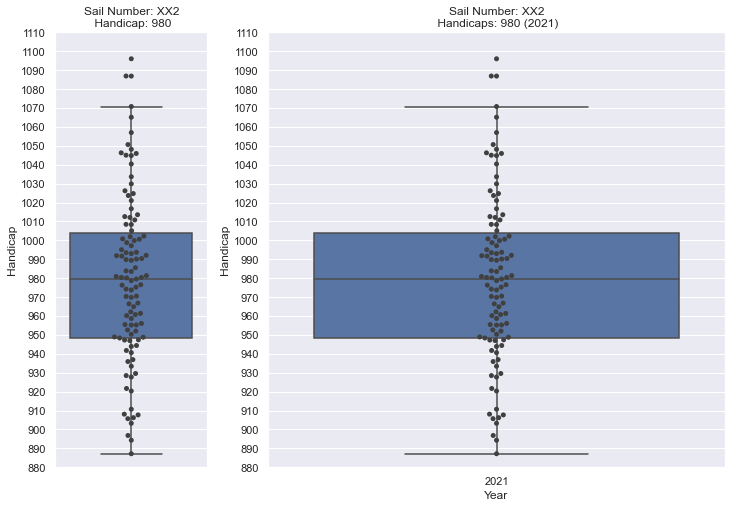

In [10]:
def handicap_plotter(race_tables, sail_number):
    handicaps_df = handicap_calculator(race_tables, sail_number)
    median_handicap = round(handicaps_df['Handicap'].median())

    fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]})
    fig.set_size_inches(12, 8)

    sns.boxplot(y='Handicap', data=handicaps_df, showfliers=False, ax=ax0)
    sns.swarmplot(y='Handicap', data=handicaps_df, color=".25", ax=ax0)
    plot_title = 'Sail Number: ' + sail_number + '\n Handicap: ' + str(median_handicap)
    ax0.set(title=plot_title)
    ax0.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax0.set(ylim=(median_handicap - 100, median_handicap + 130))

    handicaps_by_year = handicaps_df.groupby('Year')['Handicap']

    sns.boxplot(x='Year', y='Handicap', data=handicaps_df, showfliers=False, ax=ax1)
    sns.swarmplot(x="Year", y='Handicap', data=handicaps_df, color=".25", ax=ax1)
    median_handicaps = handicaps_by_year.median().round().astype(int)
    plot_title = 'Sail Number: ' + sail_number + '\n Handicaps: '
    plot_title += ', '.join((str(median_handicaps.loc[i]) + ' (' + str(i) + ')'
                            for i in median_handicaps.index))
    ax1.set(title=plot_title)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.set(ylim=(median_handicap - 100, median_handicap + 130))

handicap_plotter(race_tables, 'XX2')

We see that there's a fairly substantial variation between the upper and lower quartiles, indicating some uncertainty in the true handicap. Some of this variability can be explained by grouping the handicaps by year. The 2018 handicaps are much higher than for other years; this is likely explained by a lack of experience in sailing the boat. For 2019/20/21, the results are more stable, with a median handicap of 969 (2019), 960 (2020), and 989 (2021).

In [11]:
most_common = pd.concat(race_tables)[['HelmName', 'Class', 'SailNo', 'PY']] \
  .groupby(['HelmName', 'Class', 'SailNo']) \
  .agg({'PY': ['count', 'median']}) 

most_common.columns = ['count', 'PY']

most_common = most_common.sort_values(by='count', ascending=False).head(20).reset_index()

custom_handicaps = [compute_handicap(race_tables, sail_number) for sail_number in most_common['SailNo'].values]    

most_common['Calculated PY'] = custom_handicaps
most_common['Difference'] = most_common['Calculated PY'] - most_common['PY']

offset = round(most_common['Difference'].median())

most_common.sort_values('count', ascending=False).reset_index(drop=True)

,HelmName,Class,SailNo,count,PY,Calculated PY,Difference
0,Adam Yorkston,Streaker,1588,101,1128,1127,-1
1,Jordan Levett,Oulton Rater,XX2,92,980,980,0
2,Veronica Falat,Streaker,1972,68,1128,1065,-63
3,James Nourse,Laser,189268,58,1100,1089,-11
4,Simon Beckett,Laser,180288,55,1100,1085,-15
5,George Madin,Laser Radial,7,51,1147,1130,-17
6,Andrew Hunt,Phantom,1269,48,1004,1029,25
7,Pete Matthews,Streaker,1654,45,1128,1115,-13
8,Peter Playle,Solo,4703,41,1142,1172,30
9,Jonathan Jones,Laser,213542,38,1100,1065,-35


In [12]:
handicap = round(compute_handicap(race_tables, 'XX2'))
print('Computed PY:   ', handicap)
print('Offset:        ', offset)
print('Recommended PY:', handicap - offset)

Computed PY:    980
Offset:         -6
Recommended PY: 986
